In [2]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
import dlib
from scipy.spatial import Delaunay
import cv2


## *Disclaimer* You will need to download the images from internet and the shape predictor landmark

(112, 92, 3)


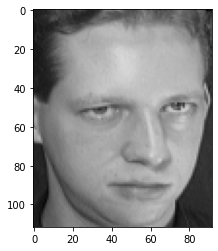

In [14]:
# read faces from att_faces
img = cv2.imread('att_faces/s1/10.pgm')
print(img.shape)
plt.imshow(img)


In [ ]:
# Calculate the area of each triangle
def triangle_area(vertices):
    # vertices is a 3x2 array representing the coordinates of the vertices of a triangle
    side1 = np.linalg.norm(vertices[1] - vertices[0])
    side2 = np.linalg.norm(vertices[2] - vertices[1])
    side3 = np.linalg.norm(vertices[0] - vertices[2])

    # Heron's formula to calculate the area of the triangle
    s = (side1 + side2 + side3) / 2.0
    area = np.sqrt(s * (s - side1) * (s - side2) * (s - side3))
    
    return area

def delaunay_triangles_area(simplices, points):
    # simplices is the list of simplices returned by scipy's Delaunay function
    # points is the array of points used to compute the Delaunay triangulation
    
    areas = []
    
    for simplex in simplices:
        # Extract the vertices of the triangle from the points array
        triangle_vertices = points[simplex]
        # Calculate the area of the triangle and append to the list
        area = triangle_area(triangle_vertices)
        areas.append(area)
    
    return areas


def getRelativeArea(img,detector,predictor):
    # show an image stored in x[0]
    # Get interest points from the image using 68 face landmarks detector
    # Get the landmarks/parts for the face in X[0]
    # Get interest points from the image using 68 face landmarks detector.
    rect = detector(img)
    if len(rect) == 0:
        return 0
    # Represent image with rectangle
    shape = predictor(img, rect[0])
    points =  np.array([(i.x, -i.y) for i in shape.parts()])
    tri = Delaunay(points) 
    areas = delaunay_triangles_area(tri.simplices, points)
    maximo = max(areas)
    areas = areas/maximo
    return np.mean(areas)



In [10]:
X=[]
y=[]
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
for i in range(1,41):
    if i != 37 and i != 33: # Esto es porque quitamos las fotos.
        images = os.listdir('./att_faces/s'+str(i))
        for image in images:
            img = cv2.imread('./att_faces/s'+str(i)+"/"+image,0)
            height1, width1 = img.shape[:2] # Esto no tiene que hacerlo todo el rato.
            img_col = np.array(img, dtype='uint8')
            rel_area = getRelativeArea(img_col,detector,predictor)
            X.append(img_col.flatten())
            y.append((i,rel_area))


Total variance explained by the selected components: 73.86%


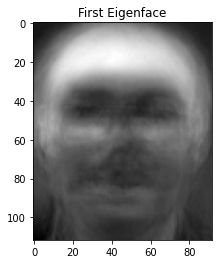

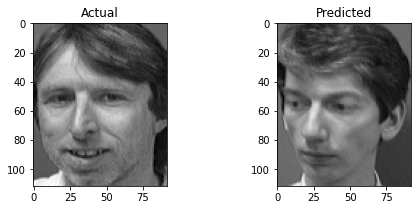

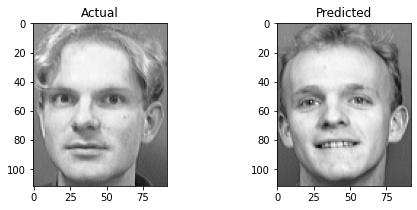

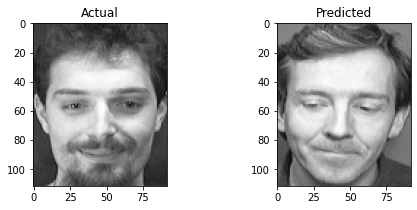

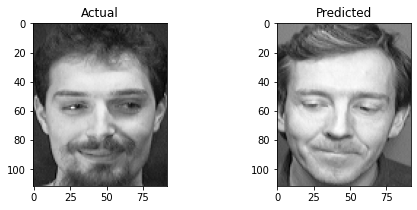

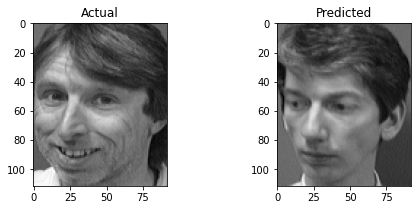

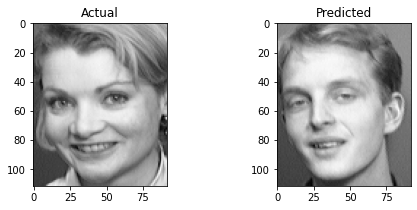

0.06315789473684211


In [22]:

# Ahora separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)
# Hago PCA sobre train
n_components = 25
pca = PCA(n_components=n_components).fit(X_train)
# Show the first eigenface
eigenfaces = pca.components_
# get total variance explained by the selected components
tot_var_exp = pca.explained_variance_ratio_.sum()
print("Total variance explained by the selected components: {:.2f}%".format(tot_var_exp*100))
plt.imshow(eigenfaces[0].reshape(height1, width1), cmap=plt.cm.gray)
plt.title("First Eigenface")
weights = eigenfaces @ (X_train - pca.mean_).T
# Vemos a ver si reconoce bien
# Para cada una del test vamos a buscar la mas cercana
incorrectos = []
for i in range(len(X_test)):
    # Obtenemos los pesos para la primera de test
    weights_test = eigenfaces @ (X_test[i] - pca.mean_).T
    # Calculamos las distancias euclideas
    distances = np.linalg.norm(weights.T - weights_test, axis=1)
    # Descomentar para usar los triangulos de Delaunay.
    # for j in range(len(distances)):
    #     distances[i]+= np.abs(y_train[j][1] - y_test[i][1])/0.001
    # Obtenemos el argmin
    argmin = np.argmin(distances)
    if y_train[argmin][0] != y_test[i][0]:
        incorrectos.append(i)
        # Show actual and predicted in a subplot
        plt.figure(figsize=(8, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(X_test[i].reshape(height1, width1), cmap=plt.cm.gray)
        plt.title("Actual")
        plt.subplot(1, 2, 2)
        plt.imshow(X_train[argmin].reshape(height1, width1), cmap=plt.cm.gray)
        plt.title("Predicted")
        plt.show()
print(len(incorrectos)/len(X_test))